# Data Source


1. Local Authority Districts (May 2023): [Office for National Statistics - Local Authority Districts (May 2023) UK BFC](https://geoportal.statistics.gov.uk/datasets/ons::local-authority-districts-may-2023-uk-bfc-2/about) This file contains the digital vector boundaries for Local Authority Districts, in the United Kingdom, as at May 2023. 
1. Regions (December 2022): [Office for National Statistics - Regions (December 2022) EN BFC](https://geoportal.statistics.gov.uk/datasets/ons::regions-december-2022-en-bfc/about) This file contains the digital vector boundaries for Regions in England as at December 2022.
1. AADF Data by direction - major roads: [Department of Transport - Road traffic statistic](https://roadtraffic.dft.gov.uk/downloads)   Number of vehicles that travel past the count point on an average day of the year, by direction of travel.
1. Major Roads Database - shape file format (2021): [Department of Transport - Road traffic statistic](https://roadtraffic.dft.gov.uk/downloads) 	Shape file of the major road network 2021.

# Analysis

In [92]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import networkx as nx
import osmnx as ox
from shapely.geometry import Polygon

<AxesSubplot:>

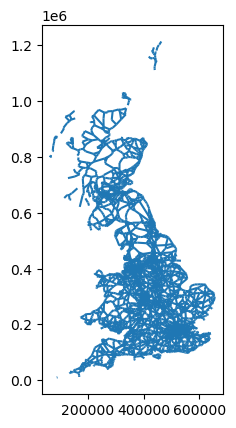

In [4]:
network = gpd.read_file('./road_network/shp/MRDB_2021.shp')
network.plot()

<AxesSubplot:>

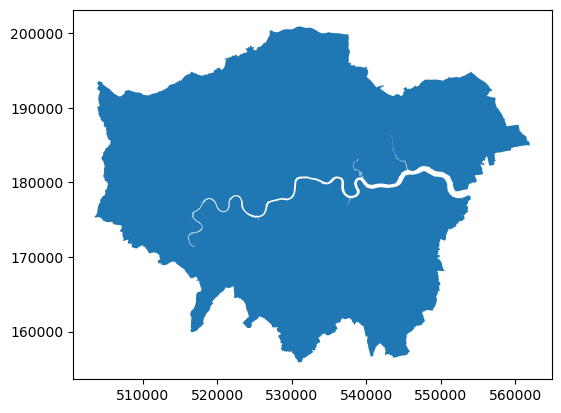

In [23]:
boundary = gpd.read_file('./road_network/shp/Regions_December_2022/RGN_DEC_2022_EN_BFC.shp')
london_boundary = boundary.query("RGN22NM=='London'")
london_boundary.to_file('./road_network/shp/london_boundary.shp')
london_boundary.plot()

<AxesSubplot:>

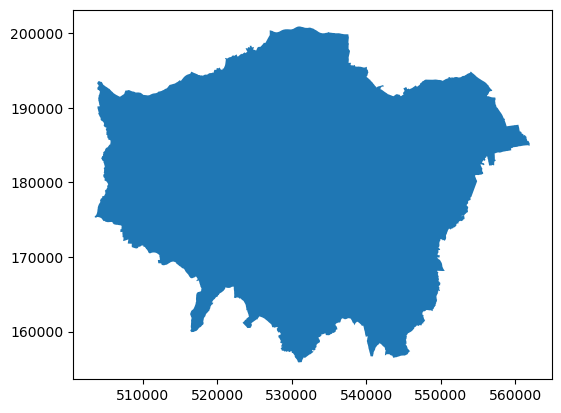

In [24]:
london_boundary = gpd.read_file('./road_network/shp/london_boundary_fixed.shp')
london_boundary.plot()

<AxesSubplot:>

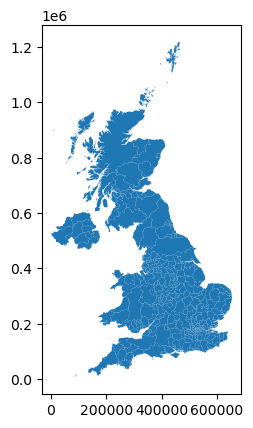

In [21]:
LAD_boundary = gpd.read_file('./road_network/shp/Local_Authority_Districts_May_2023/LAD_MAY_2023_UK_BFC.shp')
LAD_boundary.plot()

C:\Users\29425\AppData\Roaming\Python\Python39\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


<AxesSubplot:>

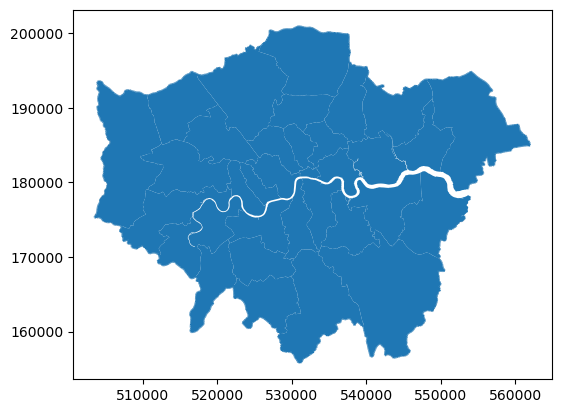

In [22]:
london_lad = LAD_boundary.intersection(london_boundary.unary_union)
london_lad.plot()

In [40]:
london_network = gpd.overlay(network, london_boundary, how='intersection').to_crs("EPSG:4326")
m = folium.Map(location=[london_network.geometry.centroid.y.mean(), london_network.geometry.centroid.x.mean()], zoom_start=12)
folium.GeoJson(london_network).add_to(m)
m

C:\Users\29425\AppData\Local\Temp\ipykernel_16452\313801139.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[london_network.geometry.centroid.y.mean(), london_network.geometry.centroid.x.mean()], zoom_start=12)
C:\Users\29425\AppData\Local\Temp\ipykernel_16452\313801139.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[london_network.geometry.centroid.y.mean(), london_network.geometry.centroid.x.mean()], zoom_start=12)


In [74]:
geometry = london_network['geometry'].explode().reset_index(drop=True)
# Creating an empty undirected graph
G = nx.Graph()


# Adding edges to the road network
for line in geometry:
    coords = list(line.coords)
    for u, v in zip(coords[:-1], coords[1:]):
        G.add_edge(u, v)


C:\Users\29425\AppData\Local\Temp\ipykernel_16452\198125845.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  geometry = london_network['geometry'].explode().reset_index(drop=True)


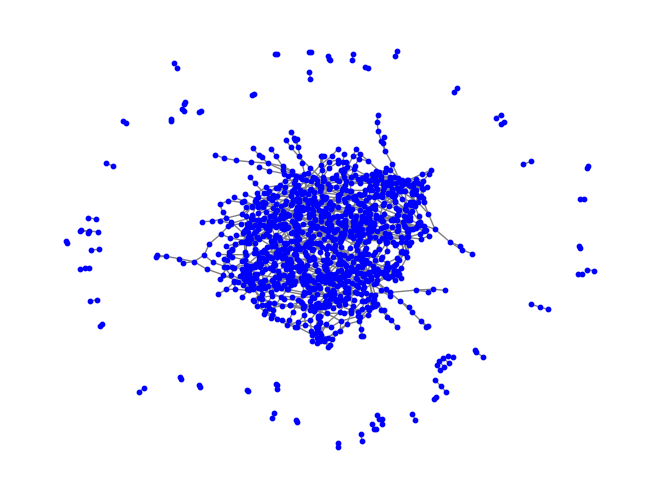

In [76]:
# Plotting Network Graphics
nx.draw(G, node_size=10, node_color='blue', edge_color='gray')

plt.show()

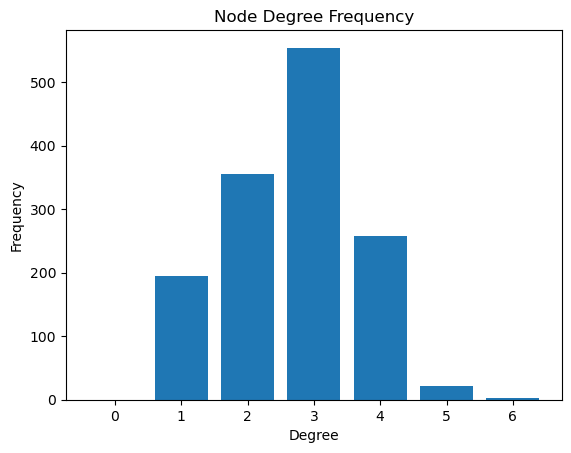

In [77]:
# Get the degree distribution of a node
degree_freq = nx.degree_histogram(G)

degrees = range(len(degree_freq))
plt.bar(degrees, degree_freq)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Node Degree Frequency')
plt.show()

数据显示，London Region范围内的主要道路网络中三向路口的数量是最多的，四向路口的数量排名第二，还有剩余少量的五向和六向路口。
The data shows that the main road network within the London Region has the highest number of three-way junctions, with the second highest number of four-way junctions and a small number of remaining five-way and six-way junctions.

In [94]:
# Get the drive Network in London area from OSM
polygon = london_boundary.to_crs("EPSG:4326")
geometry = polygon['geometry']
polygon = Polygon(geometry.iloc[0].exterior)
graph = ox.graph_from_polygon(polygon, network_type="drive", simplify=True)

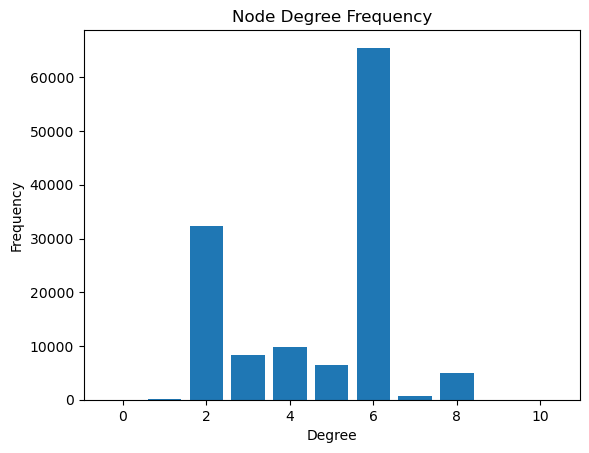

In [98]:
# Get the degree distribution of a node
degree_freq = nx.degree_histogram(graph)

degrees = range(len(degree_freq))
plt.bar(degrees, degree_freq)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Node Degree Frequency')
plt.show()